# MDP with Unmeasured Confounders

The model we are using:  
Medical Treatment model as defined in Appendix A in https://causalai.net/mdp-causal.pdf

In [80]:
def physicains_policy(St, Mt, Et):
    return (St+Mt+Et) % 2

In [81]:
import numpy as np
# probability_yt_is_1 is a 4 dimensional array
# format: probability_yt_is_1[St][Mt][Et][Xt] is P(Yt = 1 | Xt, St, Mt, Et)
probability_yt_is_1 = np.zeros((2,2,2,2))
probability_yt_is_1[0][0][0][0] = 0.2
probability_yt_is_1[0][0][0][1] = 0.9
probability_yt_is_1[0][0][1][0] = 0.9
probability_yt_is_1[0][0][1][1] = 0.2
probability_yt_is_1[0][1][0][0] = 0.8
probability_yt_is_1[0][1][0][1] = 0.3
probability_yt_is_1[0][1][1][0] = 0.3
probability_yt_is_1[0][1][1][1] = 0.8

probability_yt_is_1[1][0][0][0] = 0.7
probability_yt_is_1[1][0][0][1] = 0.2
probability_yt_is_1[1][0][1][0] = 0.2
probability_yt_is_1[1][0][1][1] = 0.7
probability_yt_is_1[1][1][0][0] = 0.1
probability_yt_is_1[1][1][0][1] = 0.8
probability_yt_is_1[1][1][1][0] = 0.8
probability_yt_is_1[1][1][1][1] = 0.1

In [82]:
# transition_prob is a 2 dimensional array
# format: transition_prob[Xt][St] = P(St+1 = 0 | St, Xt)
transition_prob = np.zeros((2,2))
transition_prob[0][0] = 0.9
transition_prob[0][1] = 0.3
transition_prob[1][0] = 0.7
transition_prob[1][1] = 0.8

In [83]:
def get_Yt(St, Mt, Et, Xt):
    u = np.random.rand()
    if u < probability_yt_is_1[St][Mt][Et][Xt]:
        return 1
    return 0

In [84]:
def get_next_state(St, Xt):
    u = np.random.rand()
    if u < transition_prob[Xt][St]:
        return 0
    return 1

# Generate data from our model

In [85]:
import pandas as pd

data_df = pd.DataFrame()

In [86]:
def generate_single_trajectory(patient_id):
    global data_df
    St = np.random.randint(2)
    for t in range(100):
        Mt, Et = np.random.randint(2), np.random.randint(2)
        Xt = physicains_policy(St, Mt, Et)
        Yt = get_Yt(St, Mt, Et, Xt)
        data_df = data_df.append({'pt_id': patient_id,'t': t, 'St': St, 'Mt': Mt, 'Et': Et, 'Xt': Xt, 'Yt': Yt}, ignore_index=True)
        St = get_next_state(St, Xt)

In [92]:
for patient_id in range(18242):
    if patient_id % 1000 == 0:
        print("Iteration number: ", patient_id)
    generate_single_trajectory(patient_id)

In [94]:
data_df.to_csv('/Users/faaiz/MDPUC/data.csv')

In [95]:
data_df.head()

,Et,Mt,St,Xt,Yt,pt_id,t
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,2.0
3,1.0,0.0,0.0,1.0,1.0,0.0,3.0
4,1.0,0.0,0.0,1.0,0.0,0.0,4.0


In [97]:
############## Define parameters #################

n_states = 2
n_actions = 2

### Divide the data into training and testing sets

In [109]:
patients = data_df['pt_id'].unique()
training = patients[np.random.randint(5, size = (len(patients))) != 4]
testing = patients[np.random.randint(5, size = (len(patients))) == 4]

train_data = data_df.loc[data_df['pt_id'].isin(training)].reset_index()
test_data = data_df.loc[data_df['pt_id'].isin(testing)].reset_index()

# Finding optimal policy assuming the confounders $E_{t}$ and $M_{t}$ are not measured
The states of MDP are $S_t$, actions are $X_t$ and rewards are $Y_t$
### 1. Estimating the Transition matrix T(S,S',A) and Reward matrix R(S,A)

In [116]:
transition = np.zeros((n_states,n_states,n_actions))
sums = np.zeros((n_states,n_actions))
R = np.zeros((n_states,n_actions))

for index, row in train_data.iterrows():
    if index < len(train_data)-1 and train_data.at[index + 1, 't'] != 0:
        S0, S1, action, Y = int(train_data.at[index, 'St']), int(train_data.at[index+1, 'St']), int(train_data.at[index, 'Xt']), int(train_data.at[index, 'Yt'])
        transition[S0][S1][action] += 1
        R[S0][action] += Y
        sums[S0][action] += 1
        
for i in range(n_states):
    for j in range(n_actions):
        if sums[i][j] != 0:
            R[i][j] = R[i][j]/sums[i][j]
            for k in range(n_states):
                transition[i][k][j] = transition[i][k][j]/sums[i][j]

Sanity Check to make sure transition matrix estimate is accurate

In [115]:
transition

array([[[0.89987782, 0.70066325],
        [0.10012218, 0.29933675]],

       [[0.29994861, 0.80034186],
        [0.70005139, 0.19965814]]])

Estimate physician's policy from data

In [172]:
physpol = (sums.T/((sums.sum(axis=1)==0) + (sums.sum(axis=1)))).T

#### MDP policy iteration util functions

In [159]:
def mdp_computePpolicyPRpolicy(P, R, policy):
    Ppolicy = np.zeros((n_states,n_states))
    PRpolicy = np.zeros(n_states)
    for a in range(n_actions):
        ind = policy==a
        if ind.sum()>0:
            for j in range(n_states):
                if ind[j]:
                    for i in range(n_states):
                        Ppolicy[j][i] = P[j][i][a]
                    PRpolicy[j] = R[j][a]
    return Ppolicy, PRpolicy

In [160]:
def mdp_eval_policy_matrix(P,R,discount,policy):
    Ppolicy, PRpolicy = mdp_computePpolicyPRpolicy(P, R, policy)
    Vpolicy = np.matmul(np.linalg.inv(np.identity(n_states) - discount*Ppolicy), PRpolicy)
    return Vpolicy

In [161]:
def mdp_bellman_operator_with_Q(P, PR, discount, Vprev):
    Q = np.zeros((n_states, n_actions))
    for a in range(n_actions):
        for i in range(n_states):
            next_step_reward = 0
            for j in range(n_states):
                next_step_reward += P[i][j][a]*Vprev[j]
            Q[i][a] = PR[i][a] + discount*next_step_reward
    V = Q.max(axis = 1)
    policy = Q.argmax(axis = 1)
    return V, Q, policy

In [162]:
def mdp_policy_iteration_with_Q(P, R, discount, policy0, max_iter=1000):
    i = 0
    policy = policy0
    is_done = False
    while not is_done:
        i += 1
        V = mdp_eval_policy_matrix(P,R,discount,policy)
        nil, Q, policy_next = mdp_bellman_operator_with_Q(P,R,discount,V)
        n_different = (policy_next != policy).sum()
        if n_different == 0 or i == max_iter or (i > 20 and n_different <= 5):
            is_done = True
        else:
            policy = policy_next
    return V, policy, i, Q

### 2. Do policy iteration

In [163]:
gamma = 0.99
_, _, i, Qon = mdp_policy_iteration_with_Q(transition, R, gamma, np.ones(n_states))
OptimalAction = Qon.argmax(axis=1) # deterministic

In [164]:
Qon

array([[23.8969691 , 23.87507313],
       [23.73126535, 23.78559731]])

### 3. Off policy evaluation on Test dataset

In [178]:
# behaviour policy is the physician's policy
p = 0.01
softpi = physpol.copy()
for i in range(n_states):
    zeros = softpi[i]==0
    if zeros.sum() > 0 and (~zeros).sum() > 0:
            z = p/zeros.sum()
            softpi[i][zeros] = z
            nz = p/(~zeros).sum()
            softpi[i][~zeros] = softpi[i][~zeros] - nz

In [180]:
# evaluation policy is epsilon greedy version of OptimalAction
softb = np.zeros((n_states, n_actions)) + p/(n_actions-1)
for i in range(n_states):
    softb[i][OptimalAction[i]] = 1-p

In [182]:
OPevaluation_data = test_data.copy()
for index, row in OPevaluation_data.iterrows():
    OPevaluation_data.at[index, 'softpi(s,a)'] = softpi[int(row['St'])][int(row['Xt'])]
    OPevaluation_data.at[index, 'softb(s,a)'] = softb[int(row['St'])][int(row['Xt'])]
    OPevaluation_data.at[index, 'optimal_action'] = OptimalAction[int(row['St'])]

In [190]:
OPevaluation_data.head()

,index,Et,Mt,St,Xt,Yt,pt_id,t,"softpi(s,a)","softb(s,a)",optimal_action
0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.499634,0.01,0.0
1,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.499634,0.01,0.0
2,2,0.0,1.0,0.0,1.0,1.0,0.0,2.0,0.499634,0.01,0.0
3,3,1.0,0.0,0.0,1.0,1.0,0.0,3.0,0.499634,0.01,0.0
4,4,1.0,0.0,0.0,1.0,0.0,0.0,4.0,0.499634,0.01,0.0


#### Off Policy Evaluation util functions

In [191]:
def OffpolicyQlearning(data, gamma, alpha, numtraces):
    sumQ = np.zeros(numtraces)
    Q = np.zeros((n_states, n_actions))
    maxavgQ = 1
    modu = 100
    first_step = data[data['t'] == 0].index
    nrepi = len(first_step)
    j = 0
    done = False
    while j < numtraces and not done:
        i = first_step[np.random.randint(nrepi-1)] # pick one episode randomly (not the last one!)
        trace = pd.DataFrame()
        
        while data.at[i+1, 't'] != 0:
            s_a_r = {'S1': data.at[i+1, 'St'],\
                     'a1': data.at[i+1, 'Xt'],\
                     'r1': data.at[i+1, 'Yt']}
            trace = trace.append(s_a_r, ignore_index=True)
            i+=1
        tracelength = len(trace)
        return_t = trace.at[tracelength-1, 'r1'] # get last reward as return for penultimate state and action
        for t in range(tracelength -2, -1, -1):
            s, a = int(trace.at[t, 'S1']), int(trace.at[t, 'a1'])
            Q[s][a] = (1-alpha)*Q[s][a] + alpha*return_t
            return_t = return_t*gamma + trace.at[t, 'r1']
            
        sumQ[j] = Q.sum()
        j = j + 1
        if j > 0 and (j % modu*500) == 0:
            s = sumQ[j-modu*500:].mean()
            if maxavgQ==0:
                d = np.nan
            else:
                d = (s - maxavgQ)/maxavgQ
            if abs(d)<0.001:
                done = True
            maxavgQ = s
    return Q, sumQ
        

In [196]:
def offpolicy_eval_tdlearning(data,physpol, gamma ,num_iter):
    bootql = np.zeros(num_iter)
    patients = data['pt_id'].unique()
    prop = 5000/len(patients) # 5000 patients of the samples are used
    prop = min(prop, 0.75) # max possible value is 0.75 (75% of the samples are used)
    a = data.loc[data['t']==0, 'St']
    d = np.zeros(n_states) # initial state distribution
    for i in range(n_states):
        d[i] = (a==i).sum()
    for i in range(num_iter):
        chosen = np.floor(np.random.rand(len(patients)) + prop)
        q = data.loc[data['pt_id'].isin(patients[chosen==1])].reset_index()
        Qoff, _ = OffpolicyQlearning( q , gamma, 0.1, 3000)
    
        V = np.zeros((n_states, n_actions))
        for k in range(n_states):
            for l in range(n_actions):
                V[k][l] = physpol[k][l]*Qoff[k][l]

        Vs = V.sum(axis=1)
        bootql[i] = (Vs*d).sum()/d.sum()
    
    return bootql

In [206]:
def offpolicy_eval_wis(data,gamma ,num_iter):
    bootwis = np.zeros(num_iter)
    patients = data['pt_id'].unique()
    prop = 25000/len(patients) # 25000 patients of the samples are used
    prop = min(prop, 0.75) # max possible value is 0.75 (75% of the samples are used)
    for jj in range(num_iter):
        chosen = np.floor(np.random.rand(len(patients)) + prop)
        q = data.loc[data['pt_id'].isin(patients[chosen==1])].reset_index()
        fence_posts = q.loc[q['t']==0].index
        num_of_trials = len(fence_posts)
        individual_trial_estimators = np.empty(num_of_trials)
        individual_trial_estimators[:] = np.nan
        rho_array = np.empty(num_of_trials)
        rho_array[:] = np.nan
        c = 0
        for i in range(num_of_trials - 1):
            rho = 1
            for t in range(fence_posts[i], fence_posts[i+1]-1):
                if q.at[t,'softpi(s,a)'] == 0:
                    rho = np.nan
                else:
                    rho = rho*q.at[t,'softb(s,a)']/q.at[t,'softpi(s,a)']
            if rho > 0:
                c += 1
            rho_array[i] = rho
        normalization = np.nansum(rho_array)
        for i in range(num_of_trials - 1):
            current_trial_estimator = 0
            rho = 1
            discount = 1/gamma
            for t in range(fence_posts[i], fence_posts[i+1]-1):
                if q.at[t,'softpi(s,a)'] == 0:
                    rho = np.nan
                else:
                    rho = rho*q.at[t,'softb(s,a)']/q.at[t,'softpi(s,a)']
                discount  = discount*gamma
                current_trial_estimator = current_trial_estimator + discount * q.at[t+1, 'Yt']
            individual_trial_estimators[i] =  current_trial_estimator*rho
        bootwis[jj] = np.nansum(individual_trial_estimators)/normalization
    individual_trial_estimators = (individual_trial_estimators/rho_array)[rho_array != np.nan]
    return bootwis

In [207]:
def offpolicy_multiple_eval(data, physpol, gamma, iter_ql, iter_wis):
    bootql = offpolicy_eval_tdlearning( data,physpol, gamma ,iter_ql)
    bootwis = offpolicy_eval_wis(data,gamma ,iter_wis)
    return bootql, bootwis

In [208]:
bootwis = offpolicy_eval_wis(OPevaluation_data,0.99,750)

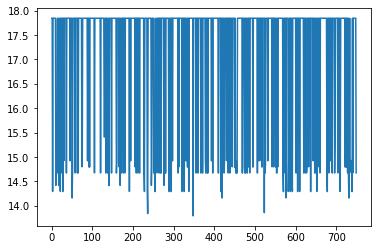

In [212]:
import matplotlib.pyplot as plt

plt.plot(bootwis)
plt.show()

In [213]:
OptimalAction

array([0, 1])